# Deep dive: Mastering Linear regression

In [1]:
# Loading the Sales data from cheat sheet #1
import os
import pandas as pd
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Load a DataFrame with a specific version of a CSV
adsSales = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "thorgodofthunder/tvradionewspaperadvertising/versions/1",
    "Advertising.csv",
)

# Dataset source: https://www.kaggle.com/datasets/thorgodofthunder/tvradionewspaperadvertising
# Dataset Owner: Thor God of Thunder (Kaggle)

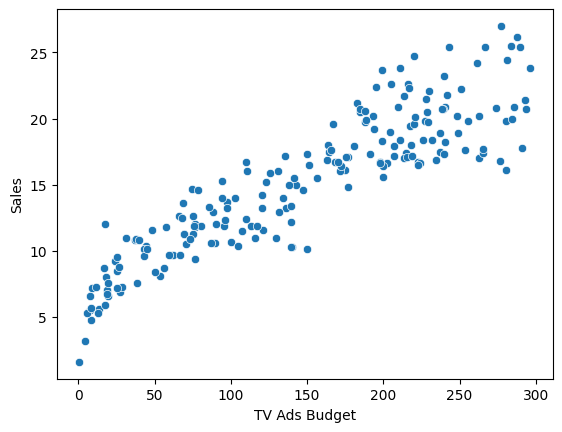

In [2]:
# Visualizing scatterplot between TV and Sales
import seaborn as sns
import matplotlib.pyplot as plt

sns.color_palette("colorblind")
sns.scatterplot(data=adsSales, x="TV", y="Sales")
plt.xlabel("TV Ads Budget")
plt.savefig("./InProgress/03-ML-CheatSheet-DeepDive-RegressionAlgorithms/EN/Images/EDA.pdf", format="pdf", bbox_inches="tight", dpi=300) # Saving the plot as .pdf
plt.show()

## Note: Point cloud between Sales and TV (advertisement budget) resembles a straight line
##       which suggest a linear relationship between TV and Sales

## Linear regression Models

For a given target variable $y$ and $L$ feature variable $x_1,\ldots,x_L$, building a linear regression relies on the assumption (which might be wrong) that the model (describing the relationship between the target and features) has the form:
$$y = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \ldots + \theta_L x_L,$$
where $\theta_0, \theta_1, \ldots, \theta_L$ are the model parameters.

Training a linear regression model consist in finding the best possible estimates of $\theta_0, \theta_1, \ldots, \theta_L$ given the data, i.e., $y$ and $x_1,\ldots,x_L$.

In our example, $y =$ "Sales", and there is 1 feature, i.e., $x_1 =$ "TV". This leads to the model:
$$\text{Sales} = \theta_0 + \theta_1 \text{TV},$$
for which the best values of $\hat\theta_0$ and $\hat\theta_1$ will be estimated given Sales and TV data.

## Estimating model parameters $\hat\theta_0$ and $\hat\theta_1$

### Method 1: Normal Equation
In linear regression there exist an exact formula to estimate model parameters. This is known as the "Normal equation". For a dataset with $N$ samples, the solution is given by
$$\hat\Theta = (X^TX)^{-1}X^TY,$$
where $\hat\Theta = [\hat\theta_1, \ldots, \hat\theta_L]^T$, $X$ is a matrix of dimension $N\times L$, i.e., all features data in the dataset, and $Y = [y_1, y_2, \ldots, y_N]^T$, i.e., all target data in the dataset.

In [3]:
# Implementation of the Normal Equation
import numpy as np

def normal_equation_fit(X, Y):
    X_exp = np.c_[np.ones((X.shape[0], 1)), X] # Add one instance to estimate theta_0
    return np.linalg.inv(X_exp.T.dot(X_exp)).dot(X_exp.T).dot(Y)

# Estimation of best model parameters for Sales and TV data
best_parameters = normal_equation_fit(adsSales[["TV"]], adsSales[["Sales"]])

best_parameters

array([[6.97482149],
       [0.05546477]])

## Model Parameters Estimates
Based on the data, the best possible estimates of the model parameters based on the Normal Equation are $\hat\theta_0 = 6.97482149$ and $\hat\theta_1 = 0.05546477$ leading to the linear model
$$\text{Sales} = 6.97482149 + 0.05546477\text{TV}.$$

## Model Predictions
For a given sample $x$, a prediction is obtained by the formula
$$\hat y = x\hat\Theta.$$

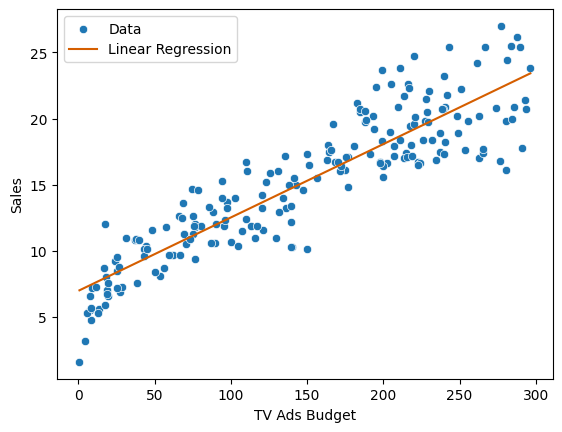

In [4]:
# Implementation of the prediction
def predict(best_parameters, X):
    X_exp = np.c_[np.ones((X.shape[0], 1)), X] # Add one instance to use theta_0
    return X_exp.dot(best_parameters)

# Making prediction Sales using TV and the model
sales_predict = predict(best_parameters, adsSales[["TV"]])
sns.scatterplot(data=adsSales, x="TV", y="Sales")
sns.lineplot(x=adsSales["TV"], y=sales_predict.ravel(), color="#d55e00")
plt.xlabel("TV Ads Budget")
plt.legend(["Data", "Linear Regression"])
plt.savefig("./InProgress/03-ML-CheatSheet-DeepDive-RegressionAlgorithms/EN/Images/linearRegression.pdf", format="pdf", bbox_inches="tight", dpi=300) # Saving the plot as .pdf
plt.show()

## Method 2: Scikit-Learn "optimized Normal Equation"
This method is optimized as it accounts for the possibility that the Normal Equation is slow for a large number of features and fails in case of multicolinearity. The solution has the form
$$\hat\Theta = X^+Y,$$
where $X^+$ is the Moore-Penrose (pseudo) inverse of $X$ and is always defined.

In [ ]:
# Training and evaluating on the training set: Linear regression
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(adsSales[["TV"]], adsSales[["Sales"]])

lin_reg.intercept_, lin_reg.coef_

## Note: Scikit-Learn and the Normal Equation lead to the same
##       linear model in this case.

(array([6.97482149]), array([[0.05546477]]))

## Method 3: Gradient Descent
Instead of an exact formulation for estimatimg model parameters, gradient descent uses a numerical approach that offers performance boost if the number of attributes $L$ or sample size $N$ is very large.

### Method 3.1: Batch Gradient Descent
The estimation starts with an initial guess $\Theta^{(0)}$ of the model parameters, then the algorithm iteratively improves the estimate at a predefined rate defined by the "learning rate" $\eta$ such that estimate at iteration $t+1$ is given by 
$$\Theta^{(t+1)} = \Theta^{(t)} - \eta\frac{2}{N}X^T\big(X\Theta^{(t)} - Y\big).$$
The algorithm will run until convergence, i.e., the difference $||\Theta^{(t+1)} - \Theta^{(t)}||_2 < \epsilon$ holds or until a predefined number of iterations $n_{\text{iter}}$ is reached. Note, $\epsilon$ is the tolerance (very small number, e.g., $10^{-8}$).

In [6]:
# Implementation of Batch gradient descent
def batch_gradient_descent_fit(X, Y, theta_0, eta=0.1, epsilon=1e-8, n_iterations=1000, keep_history=False):
    theta_prev = theta_0.copy()
    theta_next = theta_prev
    n_iter = 0

    N = X.shape[0]
    X_stand = (X - X.mean(axis=0)) / X.std(axis=0) # Standardizing the data X
    X_exp = np.c_[np.ones((N, 1)), X_stand] # Add one instance to estimate theta_0

    condition = 1 # Initialze Euclidian distance convergence condition

    theta_next_history =[theta_prev.flatten()]

    while(condition > epsilon and n_iter < n_iterations):
        grad = (2 / N) * X_exp.T.dot(X_exp.dot(theta_prev) - Y)
        theta_next = theta_prev - eta * grad

        if(keep_history):
            theta_next_history.append(theta_next.flatten()) # Save learned parameters for visualization

        condition = np.linalg.norm(theta_next - theta_prev) # Update Euclidian distance
        theta_prev = theta_next
        n_iter += 1

    return theta_next, np.array(theta_next_history)

# Estimation of best model parameters for Sales and TV data
n_coef = adsSales[["TV"]].shape[1] + 1 # Number of model parameters
np.random.seed(42)
theta_init = np.random.randn(n_coef, 1) # Initial guess
best_parameters, theta_history = batch_gradient_descent_fit(adsSales[["TV"]], adsSales[["Sales"]], theta_0=theta_init, eta=0.1, keep_history=True)

best_parameters

## Note: Batch gradient descent and the Normal Equation lead to different
##       linear model in this case. Estimates depend on initial guess.

array([[15.13049997],
       [ 4.7618855 ]])

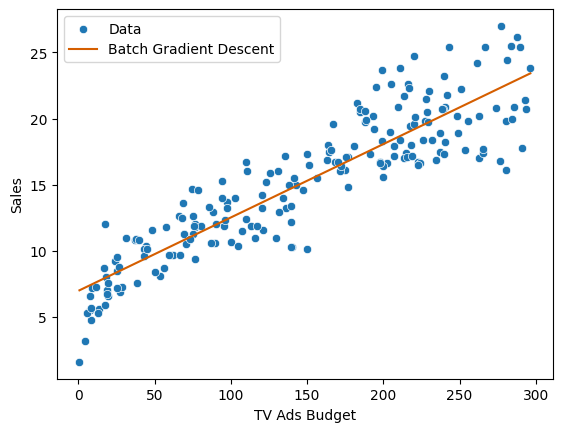

In [ ]:
# Making prediction on Sales using TV and the model
X_stand = (adsSales[["TV"]] - adsSales[["TV"]].mean(axis=0)) / adsSales[["TV"]].std(axis=0)
sales_predict = predict(best_parameters, X_stand)

sns.scatterplot(data=adsSales, x="TV", y="Sales")
sns.lineplot(x=adsSales["TV"], y=sales_predict.ravel(), color= "#d55e00")
plt.xlabel("TV Ads Budget")
plt.legend(["Data", "Batch Gradient Descent"])
plt.savefig("./InProgress/03-ML-CheatSheet-DeepDive-RegressionAlgorithms/EN/Images/batchGradientDescent_1e-1.pdf", format="pdf", bbox_inches="tight", dpi=300) # Saving the plot as .pdf
plt.show()

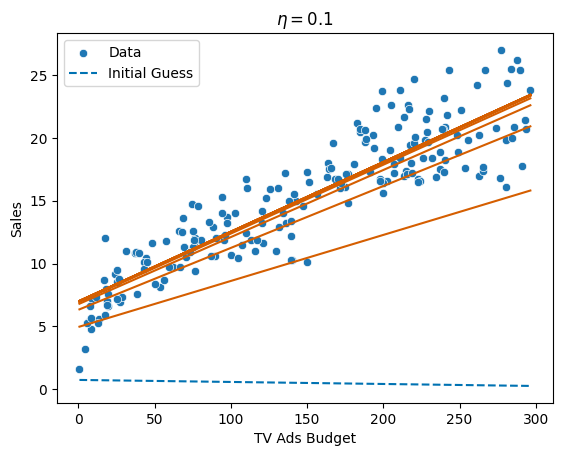

In [8]:
# Visualizing learning rate by making prediction Sales using TV and the model
X_stand = (adsSales[["TV"]] - adsSales[["TV"]].mean(axis=0)) / adsSales[["TV"]].std(axis=0)
sns.scatterplot(data=adsSales, x="TV", y="Sales")
for i in range(0, len(theta_history), 5):
    sales_predict = predict(theta_history[i, :], X_stand)
    colour_value = "#d55e00"
    linetype = "-"
    if(i == 0):
        colour_value = "#0072b2"
        linetype = "--"
    sns.lineplot(x=adsSales["TV"], y=sales_predict.ravel(), color=colour_value, linestyle=linetype)

plt.xlabel("TV Ads Budget")
plt.legend(["Data", "Initial Guess"])
plt.title("$\eta = 0.1$")
plt.savefig("./InProgress/03-ML-CheatSheet-DeepDive-RegressionAlgorithms/EN/Images/batchGradientDescentIterations_1e-1.pdf", format="pdf", bbox_inches="tight", dpi=300) # Saving the plot as .pdf
plt.show()

### Method 3.1: Stochastic Gradient Descent (SGD)
SGD improves the speed of batch gradient descent by training on one instance $X_{(j)}$ randomly picked at each iteration instead of the whole datate $X$. Moreover SGD adresses the possibility of getting stuck at a local minimum instead of the global minimum by adjusting the learning rate using a "learning schedule". Several formulae can be used to calculate the learning rate

The estimation starts with an initial guess $\Theta^{(0)}$ of the model parameters, then the algorithm iteratively improves the estimate at a predefined rate defined by the "learning rate" $\eta$ such that estimate at iteration $t+1$ is given by 
$$\Theta^{(t+1)} = \Theta^{(t)} - \eta 2X_{(j)}^T\big(X_{(j)}\Theta^{(t)} - Y_{(j)}\big).$$
The algorithm will run until convergence, i.e., the difference $||\Theta^{(t+1)} - \Theta^{(t)}||_2 < \epsilon$ holds or until a predefined number of iterations $n_{\text{iter}}$ is reached. Note, $\epsilon$ is the tolerance (very small number, e.g., $10^{-8}$).

In [ ]:
# Implementation of Stochastic gradient descent (SGD)
def learning_schedule(iter, scaling=5, smoothing=50):
    return scaling / (iter + smoothing)


def stochastic_gradient_descent_fit(X, Y, theta_0, scaling=5, smoothing=50, epsilon=1e-8, n_epochs=50, keep_history=False):
    theta_prev = theta_0.copy()
    theta_next = theta_prev
    n_epoch = 0

    N = X.shape[0]
    X_stand = (X - X.mean(axis=0)) / X.std(axis=0) # Standardizing the data X
    X_exp = np.c_[np.ones((N, 1)), X_stand] # Add one instance to estimate theta_0

    condition = 1 # Initialze Euclidian distance convergence condition

    theta_next_history =[theta_prev.flatten()]

    while(condition > epsilon and n_epoch < n_epochs):
        for i in range(N):
            random_idx = np.random.randint(N)
            x_i = X_exp[random_idx:random_idx+1]
            y_i = Y[random_idx:random_idx+1]
            grad = 2 * x_i.T.dot(x_i.dot(theta_prev) - y_i)
            eta = learning_schedule(n_epoch * N + i, scaling, smoothing)
            theta_next = theta_prev - eta * grad

        if(keep_history):
            theta_next_history.append(theta_next.flatten()) # Save learned parameters for visualization

        condition = np.linalg.norm(theta_next - theta_prev) # Update Euclidian distance
        theta_prev = theta_next
        n_epoch += 1

    return theta_next, np.array(theta_next_history)

# Estimation of best model parameters for Sales and TV data
n_coef = adsSales[["TV"]].shape[1] + 1 # Number of model parameters
np.random.seed(42)
theta_init = np.random.randn(n_coef, 1) # Initial guess
best_parameters, theta_history = stochastic_gradient_descent_fit(adsSales[["TV"]], adsSales[["Sales"]], theta_0=theta_init, scaling=1000, smoothing=250, n_epochs=1000, keep_history=True)

best_parameters

## Note: Stochastic gradient descent and the Normal Equation lead to different
##       linear model in this case. Estimates depend on initial guess.

array([[14.91703793],
       [ 4.48767259]])

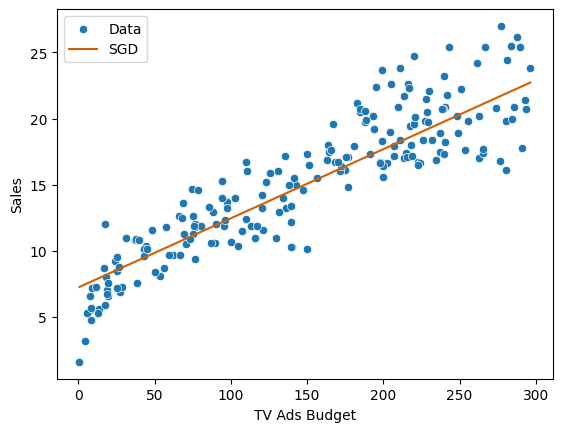

In [ ]:
# Making prediction on Sales using TV and the model
X_stand = (adsSales[["TV"]] - adsSales[["TV"]].mean(axis=0)) / adsSales[["TV"]].std(axis=0)
sales_predict = predict(best_parameters, X_stand)

sns.scatterplot(data=adsSales, x="TV", y="Sales")
sns.lineplot(x=adsSales["TV"], y=sales_predict.ravel(), color= "#d55e00")
plt.xlabel("TV Ads Budget")
plt.legend(["Data", "SGD"])
plt.savefig("./InProgress/03-ML-CheatSheet-DeepDive-RegressionAlgorithms/EN/Images/SGD_1000-250.pdf", format="pdf", bbox_inches="tight", dpi=300) # Saving the plot as .pdf
plt.show()

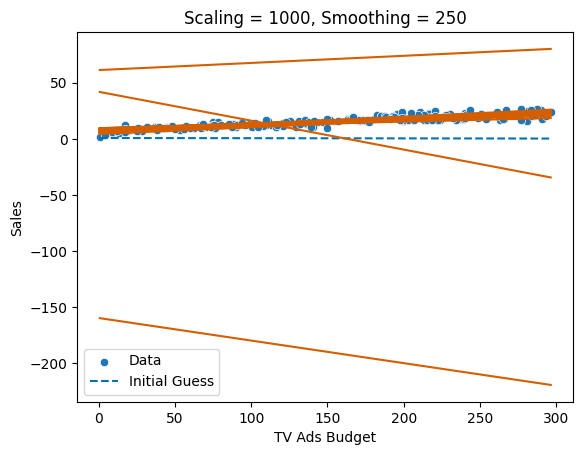

In [ ]:
# Visualizing learning rate of the SGD
X_stand = (adsSales[["TV"]] - adsSales[["TV"]].mean(axis=0)) / adsSales[["TV"]].std(axis=0)
sns.scatterplot(data=adsSales, x="TV", y="Sales")
for i in range(0, len(theta_history), 5):
    sales_predict = predict(theta_history[i, :], X_stand)
    colour_value = "#d55e00"
    linetype = "-"
    if(i == 0):
        colour_value = "#0072b2"
        linetype = "--"
    sns.lineplot(x=adsSales["TV"], y=sales_predict.ravel(), color=colour_value, linestyle=linetype)

plt.xlabel("TV Ads Budget")
plt.legend(["Data", "Initial Guess"])
plt.title("Scaling = 1000, Smoothing = 250")
plt.savefig("./InProgress/03-ML-CheatSheet-DeepDive-RegressionAlgorithms/EN/Images/SGDEpochs_1000-250.pdf", format="pdf", bbox_inches="tight", dpi=300) # Saving the plot as .pdf
plt.show()

In [ ]:
# SGD regressor using Scikit-learn
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-8, penalty=None, eta0=0.1)
sgd_reg.fit(X_stand, adsSales[["Sales"]])

sgd_reg.intercept_, sgd_reg.coef_

/media/christian/22F4BCAE291A75E1/Learning/MLenv/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(array([14.88102836]), array([4.55722987]))

# Polynomial Regression
When the data is not a straight line as is the in the "Sales vs TV" data, a more complex model such a polynomial might more accurate to capture the non-linearity. In this case the model has in the univariate case the form

$$y = \theta_0 + \theta_1 x + \theta_2 x^2 + \ldots + \theta_L x^L.$$

In our example, for a 2nd-order polynomial, the model is
$$\text{Sales} = \theta_0 + \theta_1 \text{TV} + \theta_2 \text{TV}^2.$$

The degree of the polynomial is a hyper-parameter which best value is found using a learning curve. Polynomial regression models are constructed from linear models, e.g., linear regression, and Gradient Descent.

In [13]:
# Polynomial regression using Linear Regression

from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=5, include_bias=False)
X_poly = poly_features.fit_transform(adsSales[["TV"]])

lin_reg = LinearRegression()
lin_reg.fit(X_poly, adsSales[["Sales"]])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


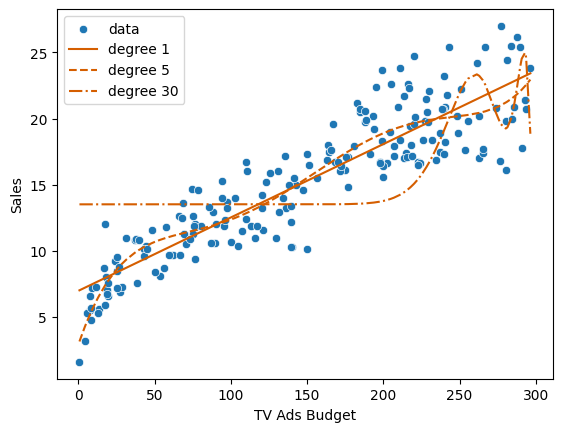

In [14]:
degrees = [1, 5, 30]
linetype_value = ["-", "--", "-."]
sns.scatterplot(data=adsSales, x="TV", y="Sales", label="data")
for degree, line in zip(degrees, linetype_value):
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly_features.fit_transform(adsSales[["TV"]])

    lin_reg = LinearRegression()
    lin_reg.fit(X_poly, adsSales[["Sales"]])

    # Visualizing the model
    sales_predict = lin_reg.predict(X_poly)
    sns.lineplot(x=adsSales["TV"], y=sales_predict.ravel(), color=colour_value, linestyle=line, label=f"degree {degree}")

plt.xlabel("TV Ads Budget")
plt.legend()
plt.savefig("./InProgress/03-ML-CheatSheet-DeepDive-RegressionAlgorithms/EN/Images/Complexity.pdf", format="pdf", bbox_inches="tight", dpi=300) # Saving the plot as .pdf
plt.show()

# Assessing model fit: Overfitting vs Underfitting

## Model complexity and generalization
1. Complex models (e.g., high-degree polynomials) closely fit the data but often perform poorly on new data: overfitting
2. Simple models (e.g., linear models) may not capture important patterns and perform poorly both on training and new data: underfitting

Trade-off: choosing the right complexity balances bias (error from choosing wrong model) and variance (error from too complex/flexible model). Increased model complexity leads typically leads to high variance and low bias, while simpler models typically have low high bias and low variance.

Model fit can be visualized using a "learning curve", showing how training and validation data errors change with training data size.

In [5]:
# Visualizing learning curve for the Sales data

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    train_errors, val_erros = [], []

    for N in range(1, len(X_train)):
        model.fit(X_train[:N], y_train[:N])
        y_train_predict = model.predict(X_train[:N])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:N], y_train_predict))
        val_erros.append(mean_squared_error(y_val, y_val_predict))
        
    plt.plot(np.sqrt(train_errors), "r-", label="train")
    plt.plot(np.sqrt(val_erros), "b-", label="validation")
    plt.xlabel("Training set size")
    plt.ylabel("RMSE")
    plt.ylim(bottom=0, top=10)
    plt.legend()

# Linear model
lin_reg = LinearRegression()
#plot_learning_curves(lin_reg, adsSales[["TV"]], adsSales[["Sales"]])

# Degree 5 polynomial
poly_features = PolynomialFeatures(degree=5, include_bias=False)
X_poly = poly_features.fit_transform(adsSales[["TV"]])
plot_learning_curves(lin_reg, X_poly, adsSales[["Sales"]])

## Note: Good fit = small RMSE + smallgap between training and validation

NameError: name 'LinearRegression' is not defined

## Improving model fit
Several method can help improve mode overfitting. One of the most common approach is regularization.

### Method 1: Ridge regression
This method allows to find the optimal values for the model parameters, e.g., $\theta_1, \theta_2, \ldots, \theta_L$ while forcing them to remain as small as possible. The exact solution for the model parameters estimates using Ridge regression is 

$$\Theta = \big(X^TX + \alpha I\big)^{-1}X^T y,$$
where $\alpha$ is the hyper-parameter controlling how much the model is regularized and $I$ is the identity matrix.

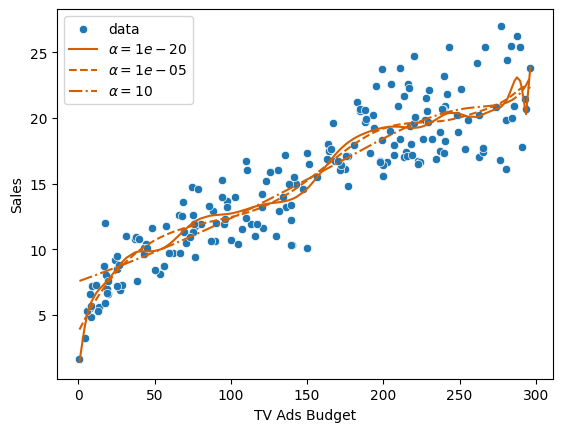

In [ ]:
# Visualizing the effect of alpha: Ridge regression

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

alphas = [1e-20, 1e-5, 10]
sns.scatterplot(data=adsSales, x="TV", y="Sales", label="data")
for alpha, line in zip(alphas, linetype_value):
    model = make_pipeline(
        PolynomialFeatures(degree=30, include_bias=False),
        StandardScaler(),
        Ridge(alpha=alpha, random_state=42)
    )
    model.fit(adsSales[["TV"]], adsSales[["Sales"]])

    # Visualizing the model
    sales_predict = model.predict(adsSales[["TV"]])
    sns.lineplot(x=adsSales["TV"], y=sales_predict.ravel(), color=colour_value, linestyle=line, label=f"$\\alpha = {alpha}$")

plt.xlabel("TV Ads Budget")
plt.legend()
plt.savefig("./InProgress/03-ML-CheatSheet-DeepDive-RegressionAlgorithms/EN/Images/Ridge_regression.pdf", format="pdf", bbox_inches="tight", dpi=300) # Saving the plot as .pdf
plt.show()

## Note: Ridge regression can also be performed with Gradient descent models by setting penalty='l2'

### Method 2: Lasso regression
Similar to Ridge ression but with a slightly different approach to force the model parameters, e.g., $\theta_1, \theta_2, \ldots, \theta_L$ to be as small as possible. Here, the model tends to set to zero coefficients $\theta_i$ for which the features $X_i$ are less important.

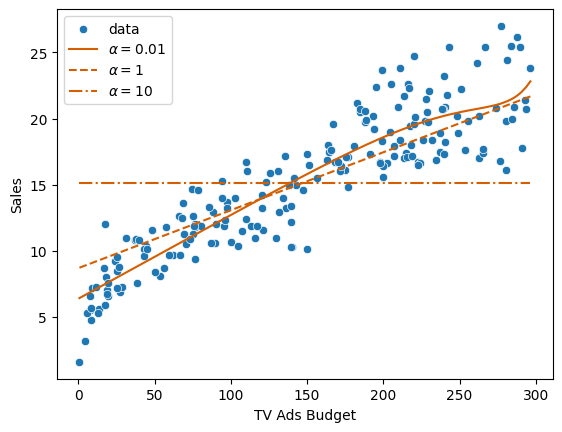

In [ ]:
# Visualizing the effect of alpha: Lasso regression

from sklearn.linear_model import Lasso

alphas = [1e-2, 1, 10]
sns.scatterplot(data=adsSales, x="TV", y="Sales", label="data")
for alpha, line in zip(alphas, linetype_value):
    model = make_pipeline(
        PolynomialFeatures(degree=30, include_bias=False),
        StandardScaler(),
        Lasso(alpha=alpha, random_state=42)
    )
    model.fit(adsSales[["TV"]], adsSales[["Sales"]])

    # Visualizing the model
    sales_predict = model.predict(adsSales[["TV"]])
    sns.lineplot(x=adsSales["TV"], y=sales_predict.ravel(), color=colour_value, linestyle=line, label=f"$\\alpha = {alpha}$")

plt.xlabel("TV Ads Budget")
plt.legend()
plt.savefig("./InProgress/03-ML-CheatSheet-DeepDive-RegressionAlgorithms/EN/Images/Lasso_regression.pdf", format="pdf", bbox_inches="tight", dpi=300) # Saving the plot as .pdf
plt.show()

## Note: Using Lasso with alpha=0 is discouraged since the algorithm is numerically unstable and does not converge.
##       Lasso regression can also be performed with Gradient descent models by setting penalty='l1'.

### Method 3: Elastic Net
It combines Ridge and Lasso regularization and the mixture is control the mixing ratio $r$ which is a hyper-parameter. When $r = 0$ Elastic Net corresponds to Ridge Regression and corresponds to Lasso Regression when $r = 1$. 

/media/christian/22F4BCAE291A75E1/Learning/MLenv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.072e+03, tolerance: 5.556e-01
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


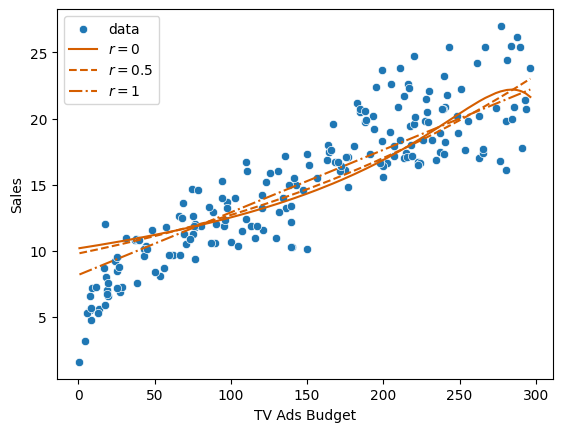

In [ ]:
# Visualizing the effect of alpha and r: Elastic Net

from sklearn.linear_model import ElasticNet

alpha = 7e-1
l1_ratios = [0, 0.5, 1]
sns.scatterplot(data=adsSales, x="TV", y="Sales", label="data")
for l1_ratio, line in zip(l1_ratios, linetype_value):
    model = make_pipeline(
        PolynomialFeatures(degree=30, include_bias=False),
        StandardScaler(),
        ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
    )
    model.fit(adsSales[["TV"]], adsSales[["Sales"]])

    # Visualizing the model
    sales_predict = model.predict(adsSales[["TV"]])
    sns.lineplot(x=adsSales["TV"], y=sales_predict.ravel(), color=colour_value, linestyle=line, label=f"$r = {l1_ratio}$")

plt.xlabel("TV Ads Budget")
plt.legend()
plt.savefig("./InProgress/03-ML-CheatSheet-DeepDive-RegressionAlgorithms/EN/Images/ElasticNet_regression.pdf", format="pdf", bbox_inches="tight", dpi=300) # Saving the plot as .pdf
plt.show()